## 0. 기본 설정

- 구글 드라이브 연결

In [ ]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
# 경로 설정    
import os
os.chdir('/content/drive/My Drive/GLM 기말 Project/Covid19-dataset')
#os.chdir('/content/drive/My Drive/대학원/2021-2학기/일반화선형모형')
os.getcwd()

'/content/drive/.shortcut-targets-by-id/10J2S6mkuhx29M134t5gQ3odcSzNwF3Gk/GLM 기말 Project/Covid19-dataset'

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import os
import time
import random 
import shutil
from skimage import io, transform
import math
import pandas as pd
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision import datasets, transforms
import torch.nn.functional as F
from torchvision.utils import make_grid
import helper
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

print("using Pytorch version", torch.__version__)

using Pytorch version 1.10.0+cu111


In [ ]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim
from torch.optim.lr_scheduler import StepLR

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os

# display images
from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
from torchsummary import summary
import time
import copy

## **모델 구조**

In [ ]:
# VGG type dict
# int : output chnnels after conv layer
# 'M' : max pooling layer
VGG_types = {
    'VGG11' : [64, 'M', 128, 'M', 256, 256, 'M', 512,512, 'M',512,512,'M'],
    'VGG13' : [64,64, 'M', 128, 128, 'M', 256, 256, 'M', 512,512, 'M', 512,512,'M'],
    'VGG16' : [64,64, 'M', 128, 128, 'M', 256, 256,256, 'M', 512,512,512, 'M',512,512,512,'M'],
    'VGG19' : [64,64, 'M', 128, 128, 'M', 256, 256,256,256, 'M', 512,512,512,512, 'M',512,512,512,512,'M']
}

In [ ]:
# define VGGnet class
class VGGnet(nn.Module):
    def __init__(self, model, in_channels=3, num_classes=3, init_weights=True):
        super(VGGnet,self).__init__()
        self.in_channels = in_channels

        # create conv_layers corresponding to VGG type
        self.conv_layers = self.create_conv_laters(VGG_types[model])

        self.fcs = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

        # weight initialization
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 512 * 7 * 7)
        x = self.fcs(x)
        return x

    # define weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    # define a function to create conv layer taken the key of VGG_type dict 
    def create_conv_laters(self, architecture):
        layers = []
        in_channels = self.in_channels # 3

        for x in architecture:
            if type(x) == int: # int means conv layer
                out_channels = x

                layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                     kernel_size=(3,3), stride=(1,1), padding=(1,1)),
                           nn.BatchNorm2d(x),
                           nn.ReLU()]
                in_channels = x
            elif x == 'M':
                layers += [nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))]
        
        return nn.Sequential(*layers)

## **그외 함수**

In [ ]:
# function to get current lr
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# function to calculate metric per mini-batch
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects


# function to calculate loss per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b
# function to calculate loss and metric per epoch

def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b
        
        if metric_b is not None:
            running_metric += metric_b
        
        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data

    return loss, metric

# function to start training
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    # # GPU out of memoty error
    # best_model_wts = copy.deepcopy(model.state_dict())

    best_loss = float('inf')

    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            # best_model_wts = copy.deepcopy(model.state_dict())

            # torch.save(model.state_dict(), path2weights)
            # print('Copied best model weights!')
            print('Get best val_loss')

        lr_scheduler.step(val_loss)

        print('train loss: %.6f, val loss: %.6f, train accuracy: %.2f, val accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*train_metric, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    # model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history

## **데이터 로드**

In [ ]:
class_names = ['Normal', 'Viral Pneumonia', 'Covid']
data_dir = '/content/drive/My Drive/GLM 기말 Project/Covid19-dataset'
#data_dir = '/content/drive/My Drive/대학원/2021-2학기/일반화선형모형/GLM 기말 Project/Covid19-dataset'

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.495, 0.495, 0.495], std=[0.273, 0.273, 0.273])
])
test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.492, 0.493, 0.494], std=[0.273, 0.273, 0.273])
])

In [ ]:
train_ds = ImageFolder(data_dir+'/train', train_transform)
test_ds = ImageFolder(data_dir+'/test', test_transform)
classes = train_ds.classes

Classes: 3 - ['Covid', 'Normal', 'Viral Pneumonia'] 
Examples: 251
Counts: {'Covid': 111, 'Normal': 70, 'Viral Pneumonia': 70}


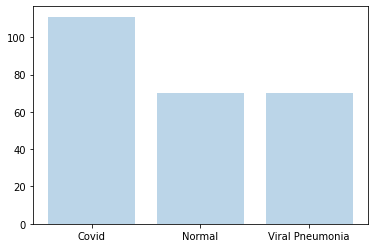

In [ ]:
def describe_dataset(data):
    classes_count = { c:0 for c in classes}
    for _,label in data:
        classes_count[classes[label]]+=1

    print(f'Classes: {len(classes)} - {classes} ')
    print(f'Examples: {len(data)}')
    print(f'Counts: {classes_count}')
    plt.bar(classes_count.keys(),classes_count.values(), alpha=0.3 )

    return classes_count

_ = describe_dataset(train_ds)


TRAIN DATASET
Classes: 3 - ['Covid', 'Normal', 'Viral Pneumonia'] 
Examples: 221
Counts: {'Covid': 97, 'Normal': 65, 'Viral Pneumonia': 59}

VALIDATION DATASET
Classes: 3 - ['Covid', 'Normal', 'Viral Pneumonia'] 
Examples: 30
Counts: {'Covid': 14, 'Normal': 5, 'Viral Pneumonia': 11}

TEST DATASET
Classes: 3 - ['Covid', 'Normal', 'Viral Pneumonia'] 
Examples: 66
Counts: {'Covid': 26, 'Normal': 20, 'Viral Pneumonia': 20}


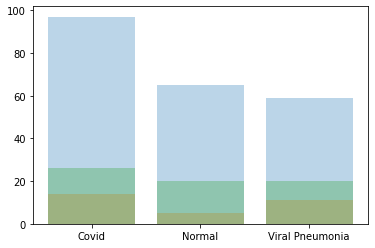

In [ ]:
from torch.utils.data import random_split
random_seed = 42
torch.manual_seed(random_seed);

val_size = 30
train_size = len(train_ds) - val_size

train_ds, val_ds = random_split(train_ds, [train_size, val_size])

print("\nTRAIN DATASET")
_=describe_dataset(train_ds)

print("\nVALIDATION DATASET")
_=describe_dataset(val_ds)

print("\nTEST DATASET")
_=describe_dataset(test_ds)

dataset = None
new_dataset = None

In [ ]:
torch.manual_seed(0)
batch_size = 16

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=3, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(train_loader))
print('Number of validation batches', len(valid_loader))
print('Number of test batches', len(test_loader))

Number of training batches 14
Number of validation batches 2
Number of test batches 5


## **모델링**

### **VGG16**

In [ ]:
# define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# creat VGGnet object
model = VGGnet('VGG16', in_channels=3, num_classes=3, init_weights=True).to(device)
print(model)

cuda
VGGnet(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3,

In [ ]:
x = torch.randn(3, 3, 224, 224).to(device)
output = model(x)
print(output.size())

torch.Size([3, 3])


In [ ]:
summary(model, (3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

In [ ]:
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=0.001)

from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=10)

In [ ]:
# definc the training parameters
params_train = {
    'num_epochs':20,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_loader,
    'val_dl':valid_loader,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

# create the directory that stores weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

In [ ]:
torch.manual_seed(0)
model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 0/19, current lr=0.001
Get best val_loss
train loss: 24.495221, val loss: 1873.887565, train accuracy: 41.63, val accuracy: 46.67, time: 0.2777 min
----------
Epoch 1/19, current lr=0.001
Get best val_loss
train loss: 4.043830, val loss: 41.650850, train accuracy: 49.77, val accuracy: 16.67, time: 0.5400 min
----------
Epoch 2/19, current lr=0.001
Get best val_loss
train loss: 2.241592, val loss: 1.083420, train accuracy: 44.80, val accuracy: 50.00, time: 0.8151 min
----------
Epoch 3/19, current lr=0.001
Get best val_loss
train loss: 1.250750, val loss: 0.979724, train accuracy: 50.23, val accuracy: 46.67, time: 1.0917 min
----------
Epoch 4/19, current lr=0.001
Get best val_loss
train loss: 1.099571, val loss: 0.821670, train accuracy: 51.13, val accuracy: 46.67, time: 1.3619 min
----------
Epoch 5/19, current lr=0.001
Get best val_loss
train loss: 0.890940, val loss: 0.741851, train accuracy: 51.58, val accuracy: 46.67, time: 1.6350 min
----------
Epoch 6/19, current lr=0.001


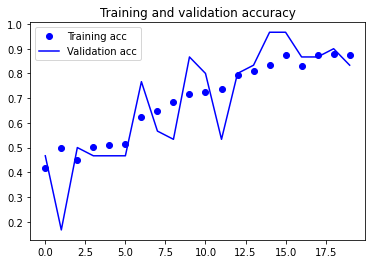

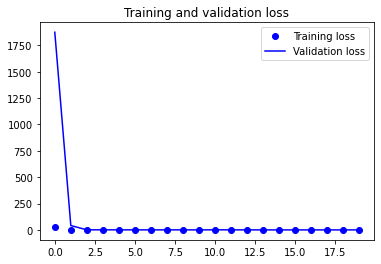

In [ ]:
import matplotlib.pyplot as plt
acc = metric_hist['train']
val_acc = metric_hist['val']
loss = loss_hist['train']
val_loss = loss_hist['val']
epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### **테스트 정확도 확인**

In [ ]:
model.eval()
with torch.no_grad():
    test_loss, test_metric = loss_epoch(model, loss_func, test_loader, sanity_check=False)

In [ ]:
test_metric

0.7878787878787878

In [ ]:
print("VGG 16 Test 정확도 : ", round(test_metric, 3), "%")

VGG 16 Test 정확도 :  0.788 %


### **VGG19**

In [ ]:
# define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# creat VGGnet object
model = VGGnet('VGG19', in_channels=3, num_classes=3, init_weights=True).to(device)
print(model)

cuda
VGGnet(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3,

In [ ]:
x = torch.randn(3, 3, 224, 224).to(device)
output = model(x)
print(output.size())

torch.Size([3, 3])


In [ ]:
summary(model, (3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

In [ ]:
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=0.001)

from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=10)

In [ ]:
# definc the training parameters
params_train = {
    'num_epochs':20,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_loader,
    'val_dl':valid_loader,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

# create the directory that stores weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

In [ ]:
torch.manual_seed(0)
model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 0/19, current lr=0.001
Get best val_loss
train loss: 18.652383, val loss: 790.056771, train accuracy: 43.89, val accuracy: 46.67, time: 0.2876 min
----------
Epoch 1/19, current lr=0.001
Get best val_loss
train loss: 2.089404, val loss: 26.912321, train accuracy: 49.32, val accuracy: 43.33, time: 0.5602 min
----------
Epoch 2/19, current lr=0.001
Get best val_loss
train loss: 1.794017, val loss: 3.175653, train accuracy: 46.15, val accuracy: 60.00, time: 0.8416 min
----------
Epoch 3/19, current lr=0.001
Get best val_loss
train loss: 1.085902, val loss: 0.794123, train accuracy: 53.85, val accuracy: 73.33, time: 1.1241 min
----------
Epoch 4/19, current lr=0.001
Get best val_loss
train loss: 1.030542, val loss: 0.614106, train accuracy: 56.11, val accuracy: 73.33, time: 1.4051 min
----------
Epoch 5/19, current lr=0.001
train loss: 0.805135, val loss: 0.674532, train accuracy: 59.28, val accuracy: 73.33, time: 1.6873 min
----------
Epoch 6/19, current lr=0.001
Get best val_loss
t

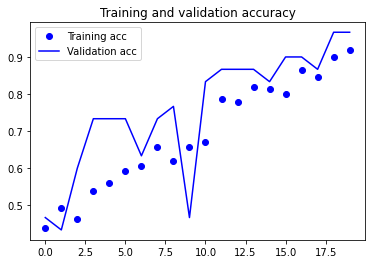

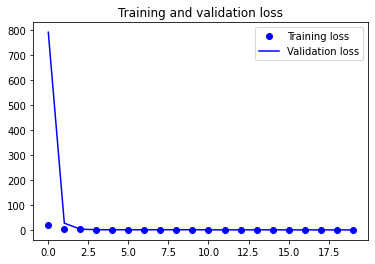

In [ ]:
import matplotlib.pyplot as plt
acc = metric_hist['train']
val_acc = metric_hist['val']
loss = loss_hist['train']
val_loss = loss_hist['val']
epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### **테스트 정확도 확인**

In [ ]:
model.eval()
with torch.no_grad():
    test_loss, test_metric = loss_epoch(model, loss_func, test_loader, sanity_check=False)

In [ ]:
test_metric

0.8333333333333334

In [ ]:
print("VGG 19 Test 정확도 : ", round(test_metric, 3), "%")

VGG 19 Test 정확도 :  0.833 %
